# Examen final Introducción a la Inteligencia artificial

## 14/08/2020

## Referencias

- [Cheatsheet de Latex](https://www.caam.rice.edu/~heinken/latex/symbols.pdf)
- []()

## Comentarios sobre el estado del documento



## Importar librerías

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from importlib import reload
# import seaborn as sns


np.random.seed(42)

from IIA_models import *
from IIA_evaluation import *

%matplotlib inline

## 2. Pre-procesamiento del dataset:

- Obtener el dataset desde el siguiente link. La primera columna representa los datos de entrada y la segunda columna representa los datos de salida.

- Levantar el dataset en un arreglo de Numpy. 

- Graficar el dataset de manera tal que sea posible visualizar la nube de puntos.

- Partir el dataset en train (80%) y test (20%).

Del gráfico scatter se puede inferir que la nube de puntos no se distribuye linealmente. Asimismo, parecería tener dos curvas, por lo que se también se descarta el polinomio de orden dos. 



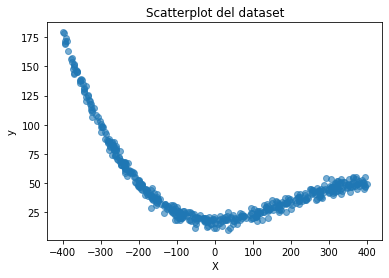

In [8]:
from IIA_preprocessing import train_test_split

filepath = 'C:/Users/jota_/00_Especialización_IA/EspecializacionIA/01_Introducción_Inteligencia_Artificial/Examen/clase_8_dataset.csv'

data = np.loadtxt(filepath, delimiter=',')

X = data[:,0]
y = data[:,1]

# Grafico de la nube de puntos

plt.scatter(X, y, alpha=0.6)

plt.title('Scatterplot del dataset')
plt.xlabel('X')
plt.ylabel('y')

plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)



Utilizar regresión polinómica para hacer “fit” sobre la nube de puntos del train. Para este ejercicio, se desea utilizar la fórmula cerrada de la optimización polinómica. El modelo es de la forma y = [Wn … W0] * [X^n    X^(n-1)    …    1]. 

Para n = 1 (modelo lineal con ordenada al origen), hacer un fit del modelo utilizando K-FOLDS. Para K-FOLDS partir el train dataset en 5 partes iguales, utilizar 4/5 para entrenar y 1/5 para validar. Informar el mejor modelo obtenido y el criterio utilizado para elegir dicho modelo (dejar comentarios en el código).

Repetir el punto (a), para n = {2,3,4}. Computar el error de validación y test del mejor modelo para cada n.

Elegir el polinomio que hace mejor fit sobre la nube de puntos y explicar el criterio seleccionado (dejar comentarios en el código). 

Graficar el polinomio obtenido y el dataset de test. 


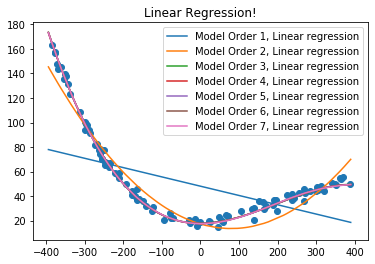

el modelo que tiene menor error cuadrático medio es el 3
Los errores cuatráticos medios registrados son: [  0.         959.24925944 101.01532538   9.81827636   9.89349644
   9.92614168   9.98067051  10.08036614]


In [9]:
from IIA_preprocessing import adapt_data_order, expand_ones_X
from IIA_evaluation import MSE, Var, Bias, k_folds_model, BaseMetric
from IIA_models import LinearRegression

# DIVIDO EN TRAIN Y VALIDATION

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 0.8)

X_train = X_train.reshape(-1, 1)
X_val = X_val.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

order = 8

evaluation = MSE
model = LinearRegression()

eval_array_val = np.zeros(order)
models = np.array([])

lock = 0
y_models = np.zeros(y_val.shape)

idx = np.argsort(X_val, axis=0)

for i in range(1, order):
    
    if i == 1:
        X_expand = X_train
        X_val_expand = X_val
    else:
        X_expand = adapt_data_order(X_train, i)
        X_val_expand = adapt_data_order(X_val, i)
        
    X_val_expand_w_ones = expand_ones_X(X_val_expand)
    X_expand_w_ones = expand_ones_X(X_expand)
    
    model.fit(X_expand_w_ones, y_train)
    
    y_pred = model.predict(X_val_expand_w_ones)
    
    eval_array_val[i] = evaluation(y_val, y_pred)()

    models = np.append(models, i)
    if lock == 0:
        y_models = y_pred
        lock += 1
    else:
        y_models = np.hstack((y_models, y_pred))   

    plt.plot(X_val[idx[:,0]], y_pred[idx[:,0]], label=f'Model Order {i}, Linear regression')

plt.legend()
plt.scatter(X_test, y_test, label=f'Model Order {i}, Linear regression')
plt.title('Linear Regression!')
plt.show()


print(f'el modelo que tiene menor error cuadrático medio es el {eval_array_val[1:].argmin() + 1}')


print(f'Los errores cuatráticos medios registrados son: {eval_array_val}')

## RESPUESTA
Se puede observar que los dos modelos a elegir son tanto el orden cúbico como el orden 4. los MSE son  muy parecidos y aproximan correctamente el modelo. Por simpleza, elijo el modelo de menor orden. 

Por lo tanto, el modelo de orden 3 será el elegido.

# 4
Para el mejor modelo seleccionado en (3c) (el mejor “n”), hacer la optimización utilizando Mini-Batch Gradient Descent (partir el train dataset en 4/5 para entrenar y 1/5 para validar).

Para cada epoch, calcular el error de train y el error de validation. 

Graficar el error de train y el error de validación en función del número de epoch.

Comparar los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c).



In [94]:
def mini_batch_gradient_descent(X, y, X_val, y_val, alpha=0.01, epochs=100, b=15):
    n = X.shape[0]
    m = X.shape[1]

    W = np.random.randint(-1, 1, size=[m, 1])
    
    error_train = np.zeros([epochs])
    error_val = np.zeros([epochs])

    for i in range(epochs):

        idx = np.random.permutation(n)
        X = X[idx]
        y = y[idx]

        batch_size = int(n / b)

        for j in range(0, n, batch_size):
            end_batch = j + batch_size if batch_size + j <= n else n

            X_batch = X[j:end_batch, :]
            y_batch = y[j:end_batch, :]

            prediction = np.matmul(X_batch, W)

            error = y_batch - prediction

            grad_sum = np.sum(error * X_batch, axis=0)
            grad_mul = -2 / n * grad_sum
            gradient = grad_mul.T.reshape(-1, 1)

            W = W - (alpha * gradient)
        
        error_train[i] = MSE(y, X.dot(W))()
        error_val[i] = MSE(y_val, X_val.dot(W))()

    return W, error_train, error_val



order = 4

X_normalized_train = (X_train - np.min(X)) / (np.max(X) - np.min(X))
X_normalized_val = (X_val - np.min(X)) / (np.max(X) - np.min(X))

X_expand = adapt_data_order(X_normalized_train, order)
X_val_expand = adapt_data_order(X_normalized_val, order)

X_train_norm_expand_w_ones = expand_ones_X(X_expand)
X_val_norm_expand_w_ones = expand_ones_X(X_val_expand)

W, error_train, error_val = mini_batch_gradient_descent(X_train_norm_expand_w_ones, y_train, X_val_norm_expand_w_ones, y_val, alpha=0.001, epochs=10000, b=15)

MSE_MiniBatch = MSE(y_val, X_val_norm_expand_w_ones.dot(W))()

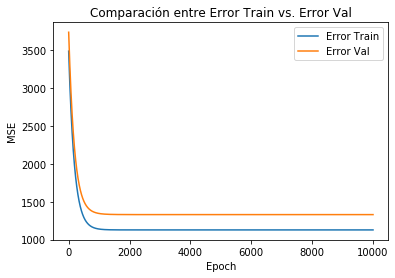

In [74]:
plt.plot(error_train, label=f'Error Train')
plt.plot(error_val, label=f'Error Val')
plt.legend()

plt.title('Comparación entre Error Train vs. Error Val')

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.show()

In [95]:
model = LinearRegression()

model.fit(X_train_norm_expand_w_ones, y_train)
y_predict = model.predict(X_val_norm_expand_w_ones)

print(f'El MSE del modelo con la solución analítica {MSE(y_val, y_predict)()}')
print(f'El MSE del modelo gradient descent con la solución analítica {MSE_MiniBatch}')

El MSE del modelo con la solución analítica 1335.9471333889944
El MSE del modelo gradient descent con la solución analítica 1329.3013674320177


## Observaciones

Como era de esperar, el resultado que arroja el modelo con la implementación en minibatch y la solución analítica son muy similares. 

Contrario a lo que uno esperaría, el modelo numérico supera la performance del modelo analítico. Eso puede fundamentarse en la mera aleatoreridad del método numérico y los puntos elegidos.

Para verificar este resultado y obtener resultados finales, compararé las performances entre ambos modelos con el TEST  DATASET.


In [96]:
order = 4

X_normalized_test = (X_test - np.min(X)) / (np.max(X) - np.min(X))
X_test_expand = adapt_data_order(X_normalized_test, order)
X_test_norm_expand_w_ones = expand_ones_X(X_test_expand)

MSE_MiniBatch = MSE(y_test, X_test_norm_expand_w_ones.dot(W))()
y_predict = model.predict(X_test_norm_expand_w_ones)

print(f'El MSE del modelo con la solución analítica {MSE(y_test, y_predict)()}')
print(f'El MSE del modelo gradient descent con la solución analítica {MSE_MiniBatch}')

El MSE del modelo con la solución analítica 1526.8632567125196
El MSE del modelo gradient descent con la solución analítica 1481.3942932099148


Nuevamente el modelo superador es el arrojado por el método numérico.

Curioso... A cenar.